<a href="https://colab.research.google.com/github/AlexanderCardarasUCSC/EEG-Decoding-to-Images/blob/main/CSE_247_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

View Results Here: https://docs.google.com/presentation/d/1nvqL58J_J7V-mPA3IU3Vue8-aH_fSJ-0lxw7-fBmng0/edit?usp=sharing

**Complete the following steps before running the cells below**

1.
Change runtime to GPU 

>Runtime > Change runtime type > GPU

2.
For each of the following link, add a Google Drive shortcut to your Drive root folder(My Drive):

>https://drive.google.com/drive/folders/1z8wcew5R7GCeu5s7SSsWw8bUcx1urVmk?usp=sharing

In [1]:
!pip install opencv-python
!pip install scikit-image
!pip install tensorflow-addons
!mkdir images

mkdir: cannot create directory ‘images’: File exists


In [2]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

flowers = get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

# fix resizing issue and save labels
def load_flowers_data(scale=True, target_shape=(64, 64), one_hot=False, interp='bilinear', extra_ohe=False):
    print("Loading Flowers dataset")
    print("Target Shape:", target_shape)
    img_gen = ImageDataGenerator() # stored as 0-255
    img_generator = img_gen.flow_from_directory(flowers,
                                                target_size=target_shape,
                                                class_mode='categorical',
                                                shuffle=False,
                                                interpolation=interp)

    data_list = []
    labels = []
    batch_index = 0

    # load images from the generator into data_list and labels
    while batch_index <= img_generator.batch_index:
        data, label = img_generator.next()
        data_list.extend(data)
        labels.extend(label)
        batch_index += 1

    # convert to numpy
    dataset = np.asarray(data_list)
    dataset = dataset.astype('int')
    labels = np.asarray(labels)

    # convert to integer
    if one_hot == False:
        new_labels = []
        for label in labels:
            new_labels.append(np.argmax(label))
        labels = new_labels
        labels = np.asarray(labels)
    else:
        if extra_ohe == True:
            temp = np.zeros((len(labels),1))
            labels = np.hstack((labels, temp))

    # scaling for tanh
    if scale:
        print("scaling values to the range [-1, 1]")
        dataset = dataset.astype('float32') # caution: storing lots of intermediate representation of image set
        dataset = (dataset - 127.5) / 127.5

    return dataset, labels

# Jason AC-GAN Base

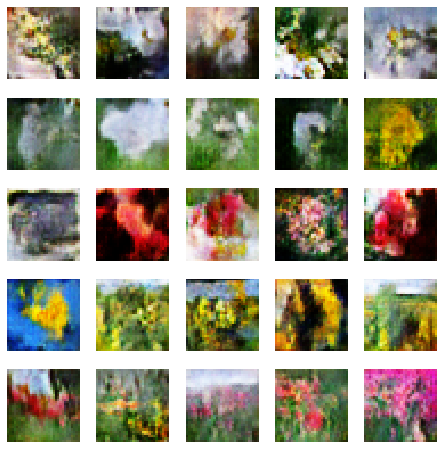

>628, 10/57, d_rf[0.653,0.650], d_class[0.074,0.019] g[0.850,0.013]
>628, 20/57, d_rf[0.706,0.596], d_class[0.214,0.017] g[0.882,0.020]
>628, 30/57, d_rf[0.629,0.662], d_class[0.090,0.055] g[0.860,0.004]
>628, 40/57, d_rf[0.728,0.647], d_class[0.130,0.047] g[0.871,0.051]
>628, 50/57, d_rf[0.675,0.685], d_class[0.276,0.059] g[0.811,0.016]
>629, 10/57, d_rf[0.641,0.629], d_class[0.083,0.088] g[0.842,0.004]
>629, 20/57, d_rf[0.578,0.654], d_class[0.081,0.026] g[0.826,0.081]
>629, 30/57, d_rf[0.652,0.630], d_class[0.227,0.061] g[0.812,0.013]
>629, 40/57, d_rf[0.589,0.724], d_class[0.163,0.017] g[0.811,0.039]


KeyboardInterrupt: 

In [52]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from IPython import display
from tensorflow_addons.layers import SpectralNormalization


# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # label input
    label_input = Input(shape=(n_classes,))
    label_embedding = Dense(4*4*256, kernel_initializer=init)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 256
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 4*4*256
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, label_embedding])
    
    # upsample to 8x8
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 16x16
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 32x32
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)
    # define model
    model = Model([in_lat, label_input], out_layer)
    return model


# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    fe = Dropout(0.1)(in_image)
    
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    # normal to 16x16
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    # downsample to 8x8
    fe = SpectralNormalization(Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init))(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    # downsample to 4x4
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes, activation='softmax')(fe)

    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model
 
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes)
    return [z_input, labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples*n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples*n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([i for j in range(n_samples) for i in range(n_classes)]), n_classes)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y
 
# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    images = g_model.predict([seed[0], seed[1]])
    images = ((images + 1)/2.0*255).astype(int)

    # plot the result
    f, axs = pyplot.subplots(5,5,figsize=(8,8))
#     pyplot.subplots_adjust(hspace=0.25, wspace=-0.89)
    pyplot.subplots_adjust(hspace=0.25, wspace=0)
    # plot images
    for i in range(25):
        axs[i%5,i//5].imshow(images[i], interpolation="none")
        axs[i%5,i//5].axis("off")
        
    display.clear_output(wait=True)
    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()
            
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        g_rf_temp, g_class_temp, d_rf_1_temp, d_rf_2_temp, d_class_1_temp, d_class_2_temp = [],[],[],[],[],[]
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            for k in range(1):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
                # update discriminator model weights
                _d_loss_1, _d_rf_1, _d_class_1 = d_model.train_on_batch(X_real, [y_real, labels_real])

                # generate 'fake' examples
                [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                _d_loss_2, _d_rf_2, _d_class_2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _g_loss, _g_rf, _g_class = gan_model.train_on_batch([z_input, labels_input], [y_gan, labels_input])

            
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                d_rf_1_temp.append(_d_rf_1)
                g_rf_temp.append(_g_rf)
                d_class_1_temp.append(_d_class_1)
                g_class_temp.append(_g_class)
            
                print('>%d, %d/%d, d_rf[%.3f,%.3f], d_class[%.3f,%.3f] g[%.3f,%.3f]' %
                    (i+1, j+1, bat_per_epo, _d_rf_1, _d_rf_2, _d_class_1, _d_class_2, _g_rf, _g_class))
                
        if i % 5 == 1:
            summarize_performance(i, g_model, latent_dim)
            d_loss1.append(sum(d_rf_1_temp) / len(d_rf_1_temp))            
            d_loss2.append(sum(d_class_1_temp) / len(d_class_1_temp))            
            g_loss1.append(sum(g_rf_temp) / len(g_rf_temp))
            g_loss2.append(sum(g_class_temp) / len(g_class_temp))

            
g_loss1, g_loss2, d_loss1, d_loss2, IS, FID = [],[],[],[],[],[]
# size of the latent space
latent_dim = 100
n_epochs = 2501
batch_size = 64
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()
dataset = load_flowers_data(target_shape=(32,32), one_hot=True)

# create a seeded latent space for visualization
seed = generate_seeded_points(latent_dim, 5)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size)

In [ ]:
g_model = generator
d_model = discriminator

### AC-GAN, N+1

In [ ]:
# def flatten(x):
#     return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])

# def Attention2D(x, channels):
#     init = RandomNormal(stddev=0.02)


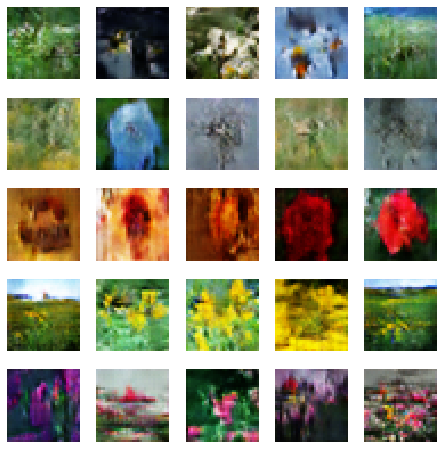

time elapsed:  10.825022220611572
>850, 10/57, d_rf[0.160,0.290], d_class[0.288,0.315] g[2.338,3.581]
>850, 20/57, d_rf[0.188,0.478], d_class[0.358,0.612] g[2.930,4.686]
>850, 30/57, d_rf[0.264,0.147], d_class[0.236,0.136] g[2.606,4.508]
>850, 40/57, d_rf[0.314,0.277], d_class[0.392,0.103] g[2.430,3.708]


In [ ]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from IPython import display
from tensorflow_addons.layers import SpectralNormalization
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Permute
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Softmax
import tensorflow as tf


def attention(x, channels):
    init = RandomNormal(stddev=0.02)
    
    f = Conv2D(channels//8, (1,1), padding='same', kernel_initializer=init)(x)
    g = Conv2D(channels//8, (1,1), padding='same', kernel_initializer=init)(x)
    h = Conv2D(channels, (1,1), padding='same', kernel_initializer=init)(x)
    
#     s = tf.linalg.matmul(flatten(g), flatten(f), transpose_b=True)
    B, W, H, C = x.shape
    N = W*H
    
#     print("fe",fe.shape)
#     print("f",f.shape)
    
    f = Reshape((f.shape[3], N))(f) # BxCxN
    print("f",f.shape)
    
    f = Permute((2,1))(f)    # BxNxC
    print("f",f.shape)
    
    g = Reshape((g.shape[3], N))(g) # BxCxN
    print("g",g.shape)
    
    s = Dot((1,2))([g,f]) # BxNxN
    print("s",s.shape)
    
    attention = Softmax()(s) # BxNxN
    print("att",attention.shape)
    
    h = Reshape((h.shape[3], N))(h) # BxCxN
    print("h",h.shape)
    
    o = Dot((1,2))([attention,h]) # BxNxC
    print("o",o.shape)
    
    gamma = tf.compat.v1.get_variable("gamma", [1], trainable=False, initializer=tf.constant_initializer(0.9))
    
    o = Reshape((W,H,C))(o) # BxCxN
    print("o",o.shape)
    
    o = Conv2D(channels, (1,1), padding='same', kernel_initializer=init)(o)
    
    x = gamma*o + x
    return x

# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # label input
    label_input = Input(shape=(n_classes+1,))
    label_embedding = Dense(4*4*256, kernel_initializer=init)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 128
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    gen = Dense(4*4*256, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, label_embedding])
    
    # upsample to 8x8
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 16x16
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    gen = attention(gen,128)
    
    # upsample to 32x32
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)

    # define model
    model = Model([in_lat, label_input], out_layer)
    return model
    

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 16x16
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    fe = attention(fe,128)
    
    # downsample to 8x8
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # downsample to 4x4
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # real/fake output
    out1 = Dense(1, activation='sigmoid')(fe)
    # class label output
    out2 = Dense(n_classes+1, activation='softmax')(fe)

    # define model
    model = Model(in_image, [out1, out2])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss=['binary_crossentropy', 'categorical_crossentropy'], optimizer=opt)
    return model
 
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes+1)
    fake_labels = to_categorical([(n_classes) for _ in range(n_samples)], n_classes+1)
#     print(fake_labels)
    return [z_input, labels, fake_labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples*n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([i for j in range(n_samples) for i in range(n_classes)]), n_classes+1)
#     print(labels)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, fake_labels = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input, fake_labels], y
 
# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, latent_dim, n_samples=100):
    # prepare fake examples
    images = g_model.predict([seed[0], seed[1]])
    images = ((images + 1)/2.0*255).astype(int)

    # plot the result
    f, axs = pyplot.subplots(5,5,figsize=(8,8))
#     pyplot.subplots_adjust(hspace=0.25, wspace=-0.89)
    pyplot.subplots_adjust(hspace=0.25, wspace=-0.0)
    # plot images
    for i in range(25):
        axs[i%5,i//5].imshow(images[i], interpolation="none")
        axs[i%5,i//5].axis("off")
        
    display.clear_output(wait=True)
    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()

    
import time
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    start = time.time()
    # manually enumerate epochs
    for i in range(n_epochs):
        g_rf_temp, g_class_temp, d_rf_1_temp, d_rf_2_temp, d_class_1_temp, d_class_2_temp = [],[],[],[],[],[]
        # enumerate batches over the training set
        end = time.time()
        print("time elapsed: ", end - start)
        start = time.time()
        for j in range(bat_per_epo):
            for k in range(1):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
                
                # update discriminator model weights
                _d_loss_1, _d_rf_1, _d_class_1 = d_model.train_on_batch(X_real, [y_real, labels_real])

                # generate 'fake' examples
                [X_fake, labels, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                _d_loss_2, _d_rf_2, _d_class_2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input, fake_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _g_loss, _g_rf, _g_class = gan_model.train_on_batch([z_input, labels_input], [y_gan, labels_input])
            
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                d_rf_1_temp.append(_d_rf_1)
                g_rf_temp.append(_g_rf)
                d_class_1_temp.append(_d_class_1)
                g_class_temp.append(_g_class)
            
                print('>%d, %d/%d, d_rf[%.3f,%.3f], d_class[%.3f,%.3f] g[%.3f,%.3f]' %
                    (i+1, j+1, bat_per_epo, _d_rf_1, _d_rf_2, _d_class_1, _d_class_2, _g_rf, _g_class))

        if i % 2 == 0:
            summarize_performance(i, g_model, latent_dim)
            d_loss1.append(sum(d_rf_1_temp) / len(d_rf_1_temp))            
            d_loss2.append(sum(d_class_1_temp) / len(d_class_1_temp))            
            g_loss1.append(sum(g_rf_temp) / len(g_rf_temp))
            g_loss2.append(sum(g_class_temp) / len(g_class_temp))
        if (i+1) % 150 == 0: 
            # evaluate the model performance, sometimes
            test_image_count = 1000
            [samples_fake, _, _], _ = generate_fake_samples(g_model, latent_dim, test_image_count)
            samples_fake = ((samples_fake + 1)/2.0*255).astype('float32')

            [samples_real, _], _ = generate_real_samples(dataset, test_image_count)
            samples_real = ((samples_real + 1)/2.0*255).astype('float32')
            
            _is = get_inception_score([sample for sample in samples_fake], splits=10)[0]
            IS.append(_is) 

            _fid = calculate_fid(samples_real, samples_fake)
            FID.append(_fid)
            
            print("IS:",_is,",FID:",_fid)
            

            
g_loss1, g_loss2, d_loss1, d_loss2, IS, FID = [],[],[],[],[],[]
# size of the latent space
latent_dim = 100
n_epochs = 1501
batch_size = 64
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)

# load image data
# dataset = load_real_samples()
# dataset = load_flowers_data(target_shape=(32,32), one_hot=True, extra_ohe=True)

# create a seeded latent space for visualization
seed = generate_seeded_points(latent_dim, 5)

# train model
train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size)

# AC-GAN, N+1, no TF

In [4]:
# example of fitting an auxiliary classifier gan (ac-gan) on fashion mnsit
import numpy as np
from numpy import zeros
from numpy import ones
from numpy import expand_dims
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import RandomNormal
from matplotlib import pyplot
from IPython import display
from tensorflow_addons.layers import SpectralNormalization


# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    
    # label input
    label_input = Input(shape=(n_classes+1,))
    label_embedding = Dense(4*4*256, kernel_initializer=init)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 256
    
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 4x4 image
    n_nodes = 4*4*256
    gen = Dense(n_nodes, kernel_initializer=init)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 256))(gen)
    
    # merge image gen and label input
    merge = Concatenate()([gen, label_embedding])
    
    # upsample to 8x8
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    # upsample to 16x16
    gen_1 = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen_1 = LeakyReLU(alpha=0.2)(gen_1)
    # upsample to 16x16
    gen_2 = Conv2DTranspose(64, (9,9), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen_2 = LeakyReLU(alpha=0.2)(gen_2)
    
    gen = Concatenate()([gen_1, gen_2])
    
    # upsample to 32x32
    gen = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    
    out_layer = Conv2DTranspose(3, (3,3), activation='tanh', padding='same', kernel_initializer=init)(gen)

    # define model
    model = Model([in_lat, label_input], out_layer)
    return model


# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=5):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=in_shape)
#     fe = Dropout(0.1)(in_image)
    
    fe = Conv2D(64, (3,3), padding='same', kernel_initializer=init)(in_image)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)    
        
    # downsample to 16x16
    fe_1 = Conv2D(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe_1 = LeakyReLU(alpha=0.2)(fe_1)
    fe_1 = Dropout(0.4)(fe_1)
    # downsample to 16x16
    fe_2 = Conv2D(64, (9,9), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe_2 = LeakyReLU(alpha=0.2)(fe_2)
    fe_2 = Dropout(0.4)(fe_2)
    
    fe = Concatenate()([fe_1, fe_2])
    
    # downsample to 8x8
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    # downsample to 4x4
    fe = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    fe = Dropout(0.4)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    
    # class label output
    out2 = Dense(n_classes+1, activation='softmax')(fe)

    # define model
    model = Model(in_image, out2)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    return model


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # connect the outputs of the generator to the inputs of the discriminator
    gan_output = d_model(g_model.output)
    # define gan model as taking noise and label and outputting real/fake and label outputs
    model = Model(g_model.input, gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='categorical_crossentropy', optimizer=opt)
    return model
 
# load images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    print(X.shape, trainy.shape)
    return [X, trainy]
 
# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes+1)
    fake_labels = to_categorical([(n_classes) for _ in range(n_samples)], n_classes+1)
#     print(fake_labels)
    return [z_input, labels, fake_labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples*n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([i for j in range(n_samples) for i in range(n_classes)]), n_classes+1)
#     print(labels)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input, fake_labels = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input, fake_labels], y
 
# generate samples and save as a plot and save the model
def summarize_performance(epoch, g_model, latent_dim, n_samples=5, n_classes=5):
    # prepare fake examples
    images = g_model.predict([seed[0], seed[1]])
    images = ((images + 1)/2.0*255).astype(int)

    # plot the result
    f, axs = pyplot.subplots(5,5,figsize=(8,8))
    pyplot.subplots_adjust(hspace=0.25, wspace=-0.0)
    
    # plot images
    for i in range(n_samples*n_classes):
        axs[i%n_classes,i//n_samples].imshow(images[i], interpolation="none")
        axs[i%n_classes,i//n_samples].axis("off")
        
    display.clear_output(wait=True)
    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        g_rf_temp, g_class_temp, d_rf_1_temp, d_rf_2_temp, d_class_1_temp, d_class_2_temp = [],[],[],[],[],[]
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            for k in range(1):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
                
                # update discriminator model weights
                _d_class_1 = d_model.train_on_batch(X_real, labels_real)

                # generate 'fake' examples
                [X_fake, labels, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                _d_class_2 = d_model.train_on_batch(X_fake, labels_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input, fake_labels] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            _g_class = gan_model.train_on_batch([z_input, labels_input], labels_input)
            
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                d_class_1_temp.append(_d_class_1)
                g_class_temp.append(_g_class)
                print('>%d, %d/%d, d_class[%.3f,%.3f] g[%.3f]' %
                    (i+1, j+1, bat_per_epo, _d_class_1, _d_class_2, _g_class))
                
        if i % 2 == 0:
            # Sample/display generated images 
            summarize_performance(i, g_model, latent_dim)
            d_loss2.append(sum(d_class_1_temp) / len(d_class_1_temp))            
            g_loss2.append(sum(g_class_temp) / len(g_class_temp))
        if (i+1) % 150 == 0: 
            # Calculate FID and IS
            test_image_count = 1000
            
            [samples_fake, _, _], _ = generate_fake_samples(g_model, latent_dim, test_image_count)
            samples_fake = ((samples_fake + 1)/2.0*255).astype('float32')
            [samples_real, _], _ = generate_real_samples(dataset, test_image_count)
            samples_real = ((samples_real + 1)/2.0*255).astype('float32')

            _is = get_inception_score([sample for sample in samples_fake], splits=10)[0]
            IS.append(_is) 
            _fid = calculate_fid(samples_real, samples_fake)
            FID.append(_fid)

            
# g_loss1, g_loss2, d_loss1, d_loss2, IS, FID = [],[],[],[],[],[]
# # size of the latent space
# latent_dim = 100
# n_epochs = 1501
# batch_size = 64
# # create the discriminator
# d_model = define_discriminator()
# # create the generator
# g_model = define_generator(latent_dim)
# # create the gan
# gan_model = define_gan(g_model, d_model)
# # load image data
# dataset = load_flowers_data(target_shape=(32,32), one_hot=True, extra_ohe=True)

# # create a seeded latent space for visualization
# seed = generate_seeded_points(latent_dim, 5)

# # train model
# train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, batch_size)

# C-GAN OHE

In [4]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from IPython import display
import tensorflow as tf
import numpy as np

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=5):
    # initialize label input
    label_input = Input(shape=(n_classes,))
    label_embedding = Dense(in_shape[0] * in_shape[1] * 3)(label_input)
    label_embedding = Reshape((in_shape[0], in_shape[1], 3))(label_embedding) # 32x32x1
    
    # initialize latent dim input
    image_input = Input(shape=in_shape)
    image_dropout = Dropout(0.4)(image_input)
    
    # combine label and noise input
    model_input = Concatenate()([image_dropout, label_embedding])
         
#     # downsample 32x32
#     model = Conv2D(64, (4,4), padding='same')(model_input)
#     model = LeakyReLU(alpha=0.2)(model)
#     model = Dropout(0.4)(model)
    
    # downsample 16 x 16
    model = Conv2D(128, (4,4), strides=(2,2), padding='same')(model_input)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.4)(model)
    
    # downsample 8 x 8 x 128
    model = Conv2D(128, (4,4), strides=(2,2), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.4)(model)
    
    # normal
    model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dropout(0.4)(model)
    
    # normal
    model = Conv2DTranspose(256, (1,1), padding='same')(model)
    model = BatchNormalization()(model)
    model = LeakyReLU(alpha=0.2)(model)
    # classifier
    model = Dropout(0.4)(model)
    model = Flatten()(model)
    output = Dense(1, activation='sigmoid')(model)
    
    discriminator = Model([image_input, label_input], output)
    
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return discriminator


# define the standalone generator model
def define_generator(latent_dim, n_classes=5):
    # initialize label input
    label_input = Input(shape=(n_classes,))
    label_embedding = Dense(8*8*256)(label_input)
    label_embedding = Reshape((8,8,256))(label_embedding) # 8 x 8 x 256

    noise_input = Input(shape=(latent_dim,))
    model = Dense(8*8*256)(noise_input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Reshape((8, 8, 256))(model)
    # merge image gen and label input
    merge = Concatenate()([model, label_embedding])
    # upsample to 16x16
    model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    model = LeakyReLU(alpha=0.2)(model)
    # upsample to 32x32
    model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
#     # upsample to 64x64
#     model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(model)
#     model = LeakyReLU(alpha=0.2)(model)
    # normal
    model = Conv2DTranspose(64, (1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # output layer
    output = Conv2D(3, (1,1), activation='tanh', padding='same')(model)
    generator = Model([noise_input, label_input], output)
    return generator


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare cifar10 training images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    Y = to_categorical(trainy, 5)
    return [X, Y]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
#     ix = randint(0, images.shape[0], n_samples)
    ix = np.random.permutation(images.shape[0])[0:n_samples]
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes)
    return [z_input, labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=5):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
#     labels = np.asarray([i for j in range(n_samples//4) for i in range(4)])
    labels = to_categorical(np.asarray([i for j in range(4) for i in range(n_samples//4)]), 5)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# create and save a plot of generated images
def save_plot(g_model, epoch):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = g_model(seed, training=False)
    predictions = ((predictions + 1)/2.0*255).numpy().astype(int)

    # plot the result
    f, axs = pyplot.subplots(5,4,figsize=(8,8))
    pyplot.subplots_adjust(hspace=0.25, wspace=-0.3
                          )
    # plot images
    for i in range(20):
        axs[i%5,i//5].imshow(predictions[i],interpolation="none")
        axs[i%5,i//5].axis("off")

    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    display.clear_output(wait=True)
    save_plot(g_model, epoch)


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=2000, n_batch=64):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        g_loss_temp, d_loss1_temp, d_loss2_temp = [],[],[]
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            for k in range(1):
                # get randomly selected 'real' samples
                [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
                # update discriminator model weights
                d_real, _ = d_model.train_on_batch([X_real, labels_real], y_real)

                # generate 'fake' examples
                [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
                # update discriminator model weights
                d_fake, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g1 = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            d_loss1_temp.append(d_real)
            d_loss2_temp.append(d_fake)
            g_loss_temp.append(g1)
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                print('>%d, %d/%d, d_real=%.3f, d_fake=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, d_real, d_fake, g1))
                
        if i % 1 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            d_loss1.append(sum(d_loss1_temp) / len(d_loss1_temp))            
            d_loss2.append(sum(d_loss2_temp) / len(d_loss2_temp))            
            g_loss.append(sum(g_loss_temp) / len(g_loss_temp))

#         # evaluate the model performance, sometimes
#         if (i+1) % 10 == 0:   
#             test_image_count = 1000
#             [samples, _], _ = generate_fake_samples(g_model, latent_dim, test_image_count)
#             samples = ((samples + 1)/2.0*255).astype(int)
#             IS.append(get_inception_score([sample for sample in samples], splits=10)[0])
    

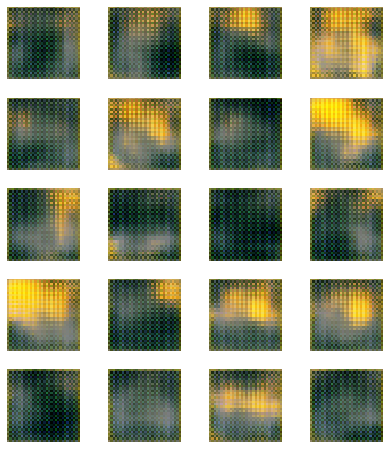

>6, 10/57, d_real=0.516, d_fake=0.828 g=3.846
>6, 20/57, d_real=1.206, d_fake=1.143 g=5.515
>6, 30/57, d_real=0.320, d_fake=0.330 g=5.367
>6, 40/57, d_real=1.324, d_fake=0.551 g=2.515
>6, 50/57, d_real=0.826, d_fake=0.096 g=3.147


KeyboardInterrupt: 

In [7]:
g_loss, d_loss1, d_loss2, IS = [],[],[],[]
# size of the latent space
latent_dim = 100
seed = generate_seeded_points(100,20)
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_flowers_data(target_shape=(32,32), one_hot=True)
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [34]:
# example of a dcgan on cifar10
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot
from IPython import display
import tensorflow as tf
import numpy as np

# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3), n_classes=10):
    # initialize label input
    label_input = Input(shape=(10,))
    label_embedding = Dense(in_shape[0] * in_shape[1] * 3)(label_input)
    label_embedding = Reshape((in_shape[0], in_shape[1], 3))(label_embedding) # 32x32x1
    
    # initialize latent dim input
    noise_input = Input(shape=in_shape)
    
    # combine label and noise input
    model_input = Concatenate()([noise_input, label_embedding])
    
    # normal
    model = Conv2D(64, (3,3), padding='same', input_shape=in_shape)(model_input)
    model = LeakyReLU(alpha=0.2)(model)
    # downsample 16 x 16 x 128
    model = Conv2D(128, (3,3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # downsample 8 x 8 x 128
    model = Conv2D(128, (3,3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # downsample
    model = Conv2D(256, (3,3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # classifier
    model = Flatten()(model)
    model = Dropout(0.4)(model)
    output = Dense(1, activation='sigmoid')(model)
    
    discriminator = Model([noise_input, label_input], output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    discriminator.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return discriminator


# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
    # initialize label input
    label_input = Input(shape=(10,))
    label_embedding = Dense(4*4*256)(label_input)
    label_embedding = Reshape((4,4,256))(label_embedding) # 4 x 4 x 256

    noise_input = Input(shape=(latent_dim,))
    model = Dense(4*4*256)(noise_input)
    model = LeakyReLU(alpha=0.2)(model)
    model = Reshape((4, 4, 256))(model)
    # merge image gen and label input
    merge = Concatenate()([model, label_embedding])
    # upsample to 8x8
    model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    model = LeakyReLU(alpha=0.2)(model)
    # upsample to 16x16
    model = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # upsample to 32x32
    model = Conv2DTranspose(64, (4,4), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    # output layer
    output = Conv2D(3, (3,3), activation='tanh', padding='same')(model)
    generator = Model([noise_input, label_input], output)
    return generator


# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare cifar10 training images
def load_real_samples():
    # load dataset
    (trainX, trainy), (_, _) = load_data()
    # expand to 3d, e.g. add channels
    X = expand_dims(trainX, axis=-1)
    # convert from ints to floats
    X = X.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    Y = to_categorical(trainy, 10)
    return [X, Y]

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = ones((n_samples, 1))
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = to_categorical(randint(0, n_classes, n_samples), n_classes)
    return [z_input, labels]

# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples, n_classes=10):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
#     labels = np.asarray([i for j in range(n_samples//4) for i in range(4)])
    labels = to_categorical(np.asarray([i for j in range(4) for i in range(n_samples//4)]),10)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [images, labels_input], y

# create and save a plot of generated images
def save_plot(g_model, epoch):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = g_model(seed, training=False)
    predictions = ((predictions + 1)/2.0*255).numpy().astype(int)

    # plot the result
    f, axs = pyplot.subplots(10,4,figsize=(16,16))
    pyplot.subplots_adjust(hspace=0.25, wspace=-0.89)
    # plot images
    for i in range(40):
        axs[i%10,i//10].imshow(predictions[i])
        axs[i%10,i//10].axis("off")

    pyplot.savefig('images/image_at_epoch_{:04d}.png'.format(epoch))
    pyplot.show()

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save plot
    display.clear_output(wait=True)
    save_plot(g_model, epoch)


# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        g_loss_temp, d_loss1_temp, d_loss2_temp = [],[],[]
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            dl1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            dl2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            gl = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            d_loss1_temp.append(dl1)
            d_loss2_temp.append(dl2)
            g_loss_temp.append(gl)
            # summarize loss on this batch
            if (j+1) % 10 == 0:
                print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                    (i+1, j+1, bat_per_epo, dl1, dl2, gl))
                
        summarize_performance(i, g_model, d_model, dataset, latent_dim)
        d_loss1.append(sum(d_loss1_temp) / len(d_loss1_temp))            
        d_loss2.append(sum(d_loss2_temp) / len(d_loss2_temp))            
        g_loss.append(sum(g_loss_temp) / len(g_loss_temp))

#         # evaluate the model performance, sometimes
#         if (i+1) % 10 == 0:   
#             test_image_count = 1000
#             [samples, _], _ = generate_fake_samples(g_model, latent_dim, test_image_count)
#             samples = ((samples + 1)/2.0*255).astype(int)
#             IS.append(get_inception_score([sample for sample in samples], splits=10)[0])
    

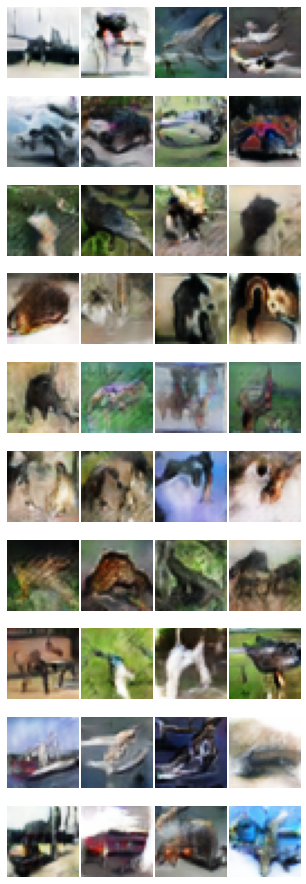

>67, 10/390, d1=0.580, d2=0.507 g=1.159
>67, 20/390, d1=0.519, d2=0.679 g=1.263
>67, 30/390, d1=0.455, d2=0.638 g=1.196
>67, 40/390, d1=0.600, d2=0.645 g=1.308
>67, 50/390, d1=0.566, d2=0.546 g=1.237
>67, 60/390, d1=0.532, d2=0.548 g=1.255
>67, 70/390, d1=0.559, d2=0.622 g=1.398
>67, 80/390, d1=0.641, d2=0.652 g=1.247
>67, 90/390, d1=0.544, d2=0.510 g=1.206
>67, 100/390, d1=0.578, d2=0.597 g=1.202
>67, 110/390, d1=0.600, d2=0.686 g=1.154
>67, 120/390, d1=0.533, d2=0.583 g=1.160
>67, 130/390, d1=0.504, d2=0.619 g=1.224
>67, 140/390, d1=0.560, d2=0.603 g=1.200
>67, 150/390, d1=0.566, d2=0.545 g=1.281
>67, 160/390, d1=0.635, d2=0.560 g=1.165
>67, 170/390, d1=0.577, d2=0.481 g=1.228
>67, 180/390, d1=0.554, d2=0.514 g=1.331
>67, 190/390, d1=0.633, d2=0.450 g=1.191
>67, 200/390, d1=0.542, d2=0.563 g=1.166
>67, 210/390, d1=0.604, d2=0.615 g=1.103
>67, 220/390, d1=0.487, d2=0.584 g=1.343
>67, 230/390, d1=0.569, d2=0.467 g=1.292
>67, 240/390, d1=0.600, d2=0.604 g=1.291
>67, 250/390, d1=0.575, d

KeyboardInterrupt: 

In [35]:
g_loss, d_loss1, d_loss2, IS = [],[],[],[]
# size of the latent space
latent_dim = 100
seed = generate_seeded_points(100,40)
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
# dataset = load_real_samples()
dataset = 
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

# Visualization

In [56]:
g_model = generator
d_model = discriminator

100


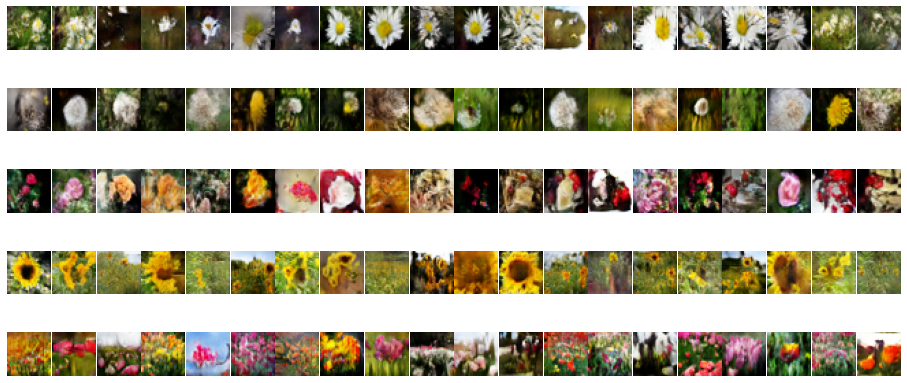

In [95]:
# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples_per_class, n_classes):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples_per_class * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples_per_class * n_classes, latent_dim)
#     print(z_input[10])
#     print(z_input[20])
    # generate labels
    labels = to_categorical(np.asarray([j for j in range(n_classes) for i in range(n_samples_per_class)]),n_classes+1)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(gen, latent_dim, n_samples_per_class, n_classes):
    # generate points in latent space
    z_input, labels_input = generate_seeded_points(latent_dim, n_samples_per_class, n_classes)
    # predict outputs
    images = gen.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples_per_class, 1))
    return [images, labels_input], y


n_samples_per_class = 20
n_classes = 5
# Notice `training` is set to False.
# This is so all layers run in inference mode (batchnorm).
predictions = generate_fake_samples(g_model, 100, n_samples_per_class, n_classes)[0][0]
predictions = ((predictions + 1)/2.0*255).astype(int)

print(len(predictions))
# plot the result
f, axs = pyplot.subplots(n_classes, n_samples_per_class, figsize=(16,16))
pyplot.subplots_adjust(hspace=-0.85, wspace=0.03)
# plot images
for i in range(n_classes):
    for j in range(n_samples_per_class):
#         print(i*n_classes + j)
        axs[i,j].imshow(predictions[(i*n_samples_per_class) + j])
        axs[i,j].axis("off")


pyplot.savefig("sample_current_epoch.png")
pyplot.show()

In [ ]:
import imageio
import glob

anim_file = 'Jason_gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('images/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        print(filename)
        image = imageio.imread(filename)
        writer.append_data(image)

In [96]:
import cv2
step = 100
n_rows = 3
n_cols = 5
pic = None
row = None

for j in range(n_rows):
    for i in range(0,n_cols):
        image_name = "images/image_at_epoch_%.4d"%((i*step) + (j*step*n_cols))+".png"
        print(image_name)

    #     img = cv2.imread(image_name)[64:-64,450:-350]
        img = cv2.imread(image_name)[64:-64,30:-60]

        if row is None:
            row = img
        else:
            row = np.hstack((row,img))
            
    if pic is None:
        pic = row
    else:
        print(pic.shape)
        
        pic = np.vstack((pic, 255*np.ones((80, pic.shape[1],3))))
        pic = np.vstack((pic, row))
    row = None
    


cv2.imwrite("seeded_evolution.png",pic)

images/image_at_epoch_0000.png
images/image_at_epoch_0100.png
images/image_at_epoch_0200.png
images/image_at_epoch_0300.png
images/image_at_epoch_0400.png
images/image_at_epoch_0500.png
images/image_at_epoch_0600.png
images/image_at_epoch_0700.png
images/image_at_epoch_0800.png
images/image_at_epoch_0900.png
(448, 2430, 3)
images/image_at_epoch_1000.png
images/image_at_epoch_1100.png
images/image_at_epoch_1200.png
images/image_at_epoch_1300.png
images/image_at_epoch_1400.png
(976, 2430, 3)


True

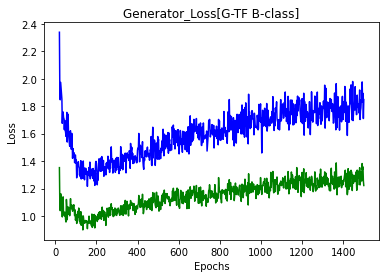

<Figure size 432x288 with 0 Axes>

In [97]:
import matplotlib.pyplot as plt
plt.title("Generator_Loss[G-TF B-class]")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot([i*2 for i in range(10,len(g_loss1))], np.array(g_loss1)[10:], color="green")
plt.plot([i*2 for i in range(10,len(g_loss2))], np.array(g_loss2)[10:], color="blue")
plt.show()
plt.savefig("Generator_Loss[G-TF_B-class.png")

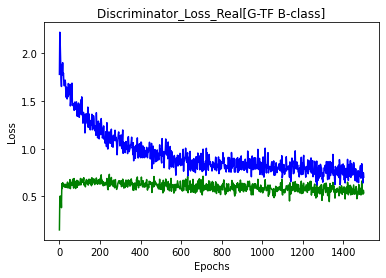

<Figure size 432x288 with 0 Axes>

In [98]:
plt.title("Discriminator_Loss_Real[G-TF B-class]")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot([i*2 for i in range(0,len(d_loss1))], np.array(d_loss1)[0:], color="green")
plt.plot([i*2 for i in range(0,len(d_loss2))], np.array(d_loss2)[0:], color="blue")
plt.show()
plt.savefig("Discriminator_Loss_Real[G-TF_B-class].png")

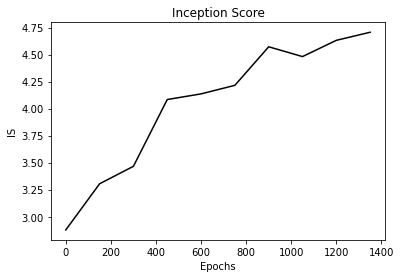

<Figure size 432x288 with 0 Axes>

In [99]:
plt.title("Inception Score")
plt.xlabel("Epochs")
plt.ylabel("IS")
plt.plot([i*150 for i in range(len(IS))], np.array(IS), color="black")
plt.show()
plt.savefig("Inception_Score.png")

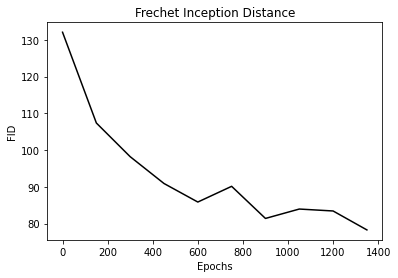

<Figure size 432x288 with 0 Axes>

In [100]:
plt.title("Frechet Inception Distance")
plt.xlabel("Epochs")
plt.ylabel("FID")
plt.plot([i*150 for i in range(len(FID))], np.array(FID), color="black")
plt.show()
plt.savefig("Frechet_Inception_Distance.png")

In [25]:
# generate points in latent space as input for the generator
def generate_seeded_points(latent_dim, n_samples_per_class, n_classes):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples_per_class * n_classes)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples_per_class * n_classes, latent_dim)
    # generate labels
    labels = to_categorical(np.asarray([j for j in range(n_classes) for i in range(n_samples_per_class)]),n_classes+1)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(gen, latent_dim, n_samples_per_class, n_classes):
    # generate points in latent space
    z_input, labels_input = generate_seeded_points(latent_dim, n_samples_per_class, n_classes)
    # predict outputs
    images = gen.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples_per_class, 1))
    return [images, labels_input], y


n_samples_per_class = 10
n_classes = 5

# This is so all layers run in inference mode (batchnorm).
predictions = generate_fake_samples(g_model, 100, n_samples_per_class, n_classes)[0][0]
predictions = ((predictions + 1)/2.0*255)
 
nearest_predictions = []
for i, prediction in enumerate(predictions):
    print("Finding nearest neighbor...", i,"/",(n_samples_per_class*n_classes))
    
    upscaled_prediction = resize(prediction, (224,224,3), 3)
    images, distances = find_nearest_neighbors(upscaled_prediction, 1)
    
    nearest_predictions.append(upscaled_prediction)
    nearest_predictions.append(images[0])

# plot the result
f, axs = pyplot.subplots(n_classes, n_samples_per_class*2, figsize=(16,16))
pyplot.subplots_adjust(hspace=-0.85, wspace=0.03)
# plot images
for i in range(n_classes):
    for j in range(n_samples_per_class*2):
        # Generated Imges
        axs[i,j].imshow(nearest_predictions[(i*n_samples_per_class*2) + j].astype(int))
        axs[i,j].axis("off")


pyplot.savefig("nearest.png")
pyplot.show()

Finding nearest neighbor... 0 / 50


NameError: name 'find_nearest_neighbors' is not defined

In [66]:
_nearest_predictions = nearest_predictions

In [57]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 3)
        # store
        images_list.append(new_image)
    return asarray(images_list)

In [1]:
scale = 5

h_padding = 10*scale
v_padding = 80*scale
padding_pair = 40*scale

images_per_row = 10
n_classes = 5

tmp_img = nearest_predictions[0].shape
predictions = scale_images(nearest_predictions,(tmp_img[0]*scale,tmp_img[1]*scale,tmp_img[2]))

image_width = predictions[0].shape[0]*scale
image_height = predictions[0].shape[1]*scale

canvas = np.ones((1450*scale,5050*scale,3)).astype(int)*255

x = 0
y = 0
for i in range(n_classes):
    for j in range(n_samples_per_class*2):
        canvas[y:y+image_height,x:x+image_width] = predictions[(i*n_samples_per_class*2) + j].astype(int)
        if j%2 == 1:
            x += padding_pair
        x += image_width + h_padding
        
    y += image_height + v_padding
    x = 0

NameError: name 'nearest_predictions' is not defined

In [ ]:
pyplot.axis("off")
pyplot.imshow(canvas)
pyplot.savefig("nearest.png")

# f, axs = pyplot.subplots(n_classes, n_samples_per_class*2, figsize=(16,16))

# Inception Score

In [3]:
import os
import numpy as np
from PIL import Image
import math
from random import randint
from PIL import Image
from tensorflow.keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import tensorflow as tf
import os.path
import tarfile
import numpy as np
from six.moves import urllib
import tensorflow as tf
import math
import sys


MODEL_DIR = '/tmp/imagenet'
DATA_URL = 'http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz'
softmax = None


# Call this function with list of images. Each of elements should be a
# numpy array with values ranging from 0 to 255.
def get_inception_score(images, splits=10):
  assert(type(images) == list)
  assert(type(images[0]) == np.ndarray)
  assert(len(images[0].shape) == 3)
  assert(np.max(images[0]) > 10)
  assert(np.min(images[0]) >= 0.0)
  inps = []
  for img in images:
    img = img.astype(np.float32)
    inps.append(np.expand_dims(img, 0))
  bs = 1
  with tf.compat.v1.Session() as sess:
    preds = []
    n_batches = int(math.ceil(float(len(inps)) / float(bs)))
    for i in range(n_batches):
        sys.stdout.write(".")
        sys.stdout.flush()
        inp = inps[(i * bs):min((i + 1) * bs, len(inps))]
        inp = np.concatenate(inp, 0)
        pred = sess.run(softmax, {'ExpandDims:0': inp})
        preds.append(pred)
    preds = np.concatenate(preds, 0)
    scores = []
    for i in range(splits):
      part = preds[(i * preds.shape[0] // splits):((i + 1) * preds.shape[0] // splits), :]
      kl = part * (np.log(part) - np.log(np.expand_dims(np.mean(part, 0), 0)))
      kl = np.mean(np.sum(kl, 1))
      scores.append(np.exp(kl))
    return np.mean(scores), np.std(scores)


# This function is called automatically.
def _init_inception():
  global softmax
  if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(MODEL_DIR, filename)
  if not os.path.exists(filepath):
    def _progress(count, block_size, total_size):
      sys.stdout.write('\r>> Downloading %s %.1f%%' % (
          filename, float(count * block_size) / float(total_size) * 100.0))
      sys.stdout.flush()
    filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, _progress)
    print()
    statinfo = os.stat(filepath)
    print('Succesfully downloaded', filename, statinfo.st_size, 'bytes.')
  tarfile.open(filepath, 'r:gz').extractall(MODEL_DIR)
  with tf.compat.v1.gfile.FastGFile(os.path.join(
      MODEL_DIR, 'classify_image_graph_def.pb'), 'rb') as f:
    graph_def = tf.compat.v1.GraphDef()
    graph_def.ParseFromString(f.read())
    _ = tf.import_graph_def(graph_def, name='')
  # Works with an arbitrary minibatch size.
  with tf.compat.v1.Session() as sess:
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')
    ops = pool3.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            shape = [s for s in shape]
            new_shape = []
            for j, s in enumerate(shape):
                if s == 1 and j == 0:
                    new_shape.append(None)
                else:
                    new_shape.append(s)
            o.set_shape(tf.TensorShape(new_shape))
    w = sess.graph.get_operation_by_name("softmax/logits/MatMul").inputs[1]
    logits = tf.matmul(tf.squeeze(pool3, [1, 2]), w)
    softmax = tf.nn.softmax(logits)


if softmax is None:
  _init_inception()

Instructions for updating:
Use tf.gfile.GFile.


# FID
**https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/**

In [4]:
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as preprocess_input_inception_v3
from tensorflow.keras.datasets.mnist import load_data
from skimage.transform import resize

# prepare the inception v3 model
fid_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))

# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return asarray(images_list)
 
# calculate frechet inception distance
def _calculate_fid(model, images1, images2):
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = numpy.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_fid(real_images, fake_images):
    r = real_images.astype("float32")
    r = scale_images(r, (299,299,3))
    r = preprocess_input_inception_v3(r)

    f = fake_images.astype("float32")
    f = scale_images(f, (299,299,3))
    f = preprocess_input_inception_v3(f)
    
    fid = _calculate_fid(fid_model, r, f)
    return fid

# Nearest Image Search
**https://www.oreilly.com/library/view/practical-deep-learning/9781492034858/ch04.html**

In [24]:
import numpy as np
from numpy.linalg import norm
import pickle
# from tqdm import tqdm, tqdm_notebook
import os
import time
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_input_resnet50
from sklearn.neighbors import NearestNeighbors

# print("Loading ResNet50 model")
_nearest_feature_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
print("Loading Images")
_nearest_image_list, _ = load_flowers_data(target_shape=(224, 224), one_hot=True, extra_ohe=True, scale=False)
print("Loading Features")
_nearest_feature_list = pickle.load(open('dataset_features.pickle', 'rb'))
print("Calculating Nearest Neighbors")
_neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute', metric='euclidean').fit(_nearest_feature_list)
print("Done")


# scale an array of images to a new size
def scale_image(image, new_shape):
    return resize(image, (224,224,3), 3)

def extract_features(img_array, model):
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input_resnet50(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

def find_nearest_neighbors(image, n_neighbors=1): 
    image = scale_image(image, (224,224,3))
    image_feature = extract_features(image, _nearest_feature_model)
    distances, indices = _neighbors.kneighbors([image_feature])
    return _nearest_image_list[indices[0][0:n_neighbors]], distances[0][0:n_neighbors]



94773248/94765736 [==============================] - 1s 0us/step
Loading Images
Loading Flowers dataset
Target Shape: (224, 224)
Found 3670 images belonging to 5 classes.
Loading Features


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_features.pickle'